# Pipeline for the anomaly detection on the SKAB using Feed Forward Autoencoder

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import sys
import warnings

import pandas as pd
from sklearn.preprocessing import StandardScaler

sys.path.append("..")
from core.Vanilla_AE import Vanilla_AE
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# hyperparameters selection
BEST_PARAMS = [5, 4, 2, 0.005, 32]
Q = 0.99  # quantile for upper control limit (UCL) selection

In [ ]:
# model defining
model = Vanilla_AE(BEST_PARAMS)

### Method fitting and applying

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(["anomaly", "changepoint"], axis=1)

    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)

    # model fitting
    model.fit(StSc.transform(X_train))

    # results predicting
    residuals_train = (
        pd.DataFrame(
            StSc.transform(X_train) - model.predict(StSc.transform(X_train))
        )
        .abs()
        .sum(axis=1)
    )
    UCL = residuals_train.quantile(Q) * 5 / 2

    df_sc = StSc.transform(df.drop(["anomaly", "changepoint"], axis=1))
    residuals_full_df = df_sc - model.predict(df_sc)
    residuals_full_df = pd.DataFrame(residuals_full_df).abs().sum(axis=1)

    prediction = pd.Series(
        (residuals_full_df > UCL).astype(int).values, index=df.index
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

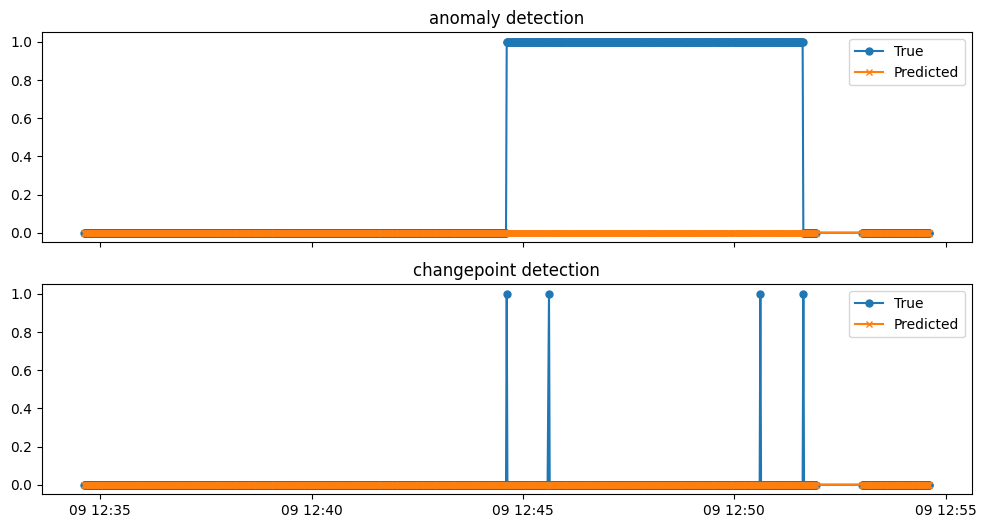

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 1.18 %
Missing Alarm Rate 75.72 %
F1 metric 0.38


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 104
A number of FPs = 60
Average time 0 days 00:00:40.840000


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  5.41
LowFP  -  -1.31
LowFN  -  8.78
